In [90]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


#######################Тут не все компании!!!######################################
#######################Тут не все компании!!!######################################
companies = ['SBER','GAZP' , 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'AFLT', 'AFKS',
       'TRNFP', 'CBOM',
       'FIVE', 'MOEX',
       'HYDR']
companies = ['SBER', 'LKOH', 'GMKN','MOEX']
######################Тут не все компании!!!##############################################
######################Тут не все компании!!!##############################################

In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [91]:
l = []
for i in companies:
    data = total_df[total_df['secid'] == i]
    l.append(data.shape[0])

max_len = min(l)
data = np.zeros((max_len, len(companies)))
for i, company in enumerate(companies):
    series = np.array(total_df[total_df.secid == company].close)[:max_len]
    data[:,i] += series

In [92]:
# train_data = data[ : round(data.shape[0]*0.55) ]
# val_data = data[ round(data.shape[0]*0.85) : ]

train_data = data[ : round(data.shape[0]*0.80) ]
val_data = data[ round(data.shape[0]*0.80) : ]

In [93]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [94]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [95]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    где исторический промежуток=lookback
    горизонт прогнозирования=horizon
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [147]:
# lookback = 104
# horizon = 1

# x_train, y_train = sample_creator(train_data, lookback, horizon)
# x_val, y_val = sample_creator(val_data, lookback, horizon)

# print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

lookback = 32
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5721, 32, 4]), y_train: torch.Size([5721, 1])
x_val: torch.Size([1553, 32, 4]), y_val: torch.Size([1553, 1])


In [97]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=4, d_model=512, nhead=8, num_layers=1, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.ebedder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.head(x[:, -1, :])  
        return x    

In [55]:
# def weights_adoptation(path):
#     state_dict = torch.load(path)
#     new_state_dict = {}
#     for key in state_dict:
#         new_key = key.replace('module.','')
#         new_state_dict[new_key] = state_dict[key]
#     return new_state_dict

# path = 'WEIGHTS/(1024,16,4,0.1)TRANS(ENC)(M F=AS)1D|||W=0.4697, VL=0.7045'

# new_weights = weights_adoptation(path)

# model = TransformerModel().to(device)
# model.load_state_dict(new_weights)

In [148]:
model = TransformerModel(input_dim=len(companies), d_model=512, nhead=8, num_layers=1, dropout=0.0).to(device)

In [152]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    #if val_loss < 0.0002:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для val_loss = {val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 39:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/100 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 100,Train Loss: 0.065635 Validation Loss: 0.022129


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 100,Train Loss: 0.003853 Validation Loss: 0.001199


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 100,Train Loss: 0.002433 Validation Loss: 0.000924


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 100,Train Loss: 0.002269 Validation Loss: 0.001304


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 100,Train Loss: 0.002074 Validation Loss: 0.001165


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 100,Train Loss: 0.002061 Validation Loss: 0.001897


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 100,Train Loss: 0.002200 Validation Loss: 0.000848


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 100,Train Loss: 0.002129 Validation Loss: 0.000664


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 100,Train Loss: 0.002061 Validation Loss: 0.001403


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 100,Train Loss: 0.002158 Validation Loss: 0.003589


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 100,Train Loss: 0.002172 Validation Loss: 0.000989


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 1.5000e-04.
Epoch 12 / 100,Train Loss: 0.001933 Validation Loss: 0.001410


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 100,Train Loss: 0.001764 Validation Loss: 0.001217


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 100,Train Loss: 0.001760 Validation Loss: 0.000591


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 100,Train Loss: 0.001678 Validation Loss: 0.000731


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 100,Train Loss: 0.001603 Validation Loss: 0.001252


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 100,Train Loss: 0.001678 Validation Loss: 0.000861


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 7.5000e-05.
Epoch 18 / 100,Train Loss: 0.001746 Validation Loss: 0.000624


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 100,Train Loss: 0.001610 Validation Loss: 0.000861


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 100,Train Loss: 0.001530 Validation Loss: 0.000491


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 100,Train Loss: 0.001532 Validation Loss: 0.000669


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 100,Train Loss: 0.001499 Validation Loss: 0.000558


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 100,Train Loss: 0.001429 Validation Loss: 0.000564


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 100,Train Loss: 0.001499 Validation Loss: 0.000448


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 100,Train Loss: 0.001574 Validation Loss: 0.000659


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 100,Train Loss: 0.001409 Validation Loss: 0.000787


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 100,Train Loss: 0.001372 Validation Loss: 0.000757


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00028: reducing learning rate of group 0 to 3.7500e-05.
Epoch 28 / 100,Train Loss: 0.001509 Validation Loss: 0.000566


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 100,Train Loss: 0.001452 Validation Loss: 0.000562


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 100,Train Loss: 0.001362 Validation Loss: 0.000540


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 100,Train Loss: 0.001380 Validation Loss: 0.000536


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 1.8750e-05.
Epoch 32 / 100,Train Loss: 0.001331 Validation Loss: 0.000540


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 100,Train Loss: 0.001342 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 100,Train Loss: 0.001338 Validation Loss: 0.000463


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 100,Train Loss: 0.001334 Validation Loss: 0.000545


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 9.3750e-06.
Epoch 36 / 100,Train Loss: 0.001301 Validation Loss: 0.000554


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 100,Train Loss: 0.001275 Validation Loss: 0.000443


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 100,Train Loss: 0.001281 Validation Loss: 0.000485


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 100,Train Loss: 0.001250 Validation Loss: 0.000451


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 100,Train Loss: 0.001295 Validation Loss: 0.000448


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00041: reducing learning rate of group 0 to 4.6875e-06.
Epoch 41 / 100,Train Loss: 0.001310 Validation Loss: 0.000513


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42 / 100,Train Loss: 0.001318 Validation Loss: 0.000523


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 100,Train Loss: 0.001265 Validation Loss: 0.000482


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 100,Train Loss: 0.001295 Validation Loss: 0.000501


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 2.3437e-06.
Epoch 45 / 100,Train Loss: 0.001291 Validation Loss: 0.000473


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46 / 100,Train Loss: 0.001277 Validation Loss: 0.000472


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 100,Train Loss: 0.001266 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 / 100,Train Loss: 0.001265 Validation Loss: 0.000481


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 1.1719e-06.
Epoch 49 / 100,Train Loss: 0.001288 Validation Loss: 0.000481


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50 / 100,Train Loss: 0.001251 Validation Loss: 0.000474


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 51 / 100,Train Loss: 0.001299 Validation Loss: 0.000469


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 52 / 100,Train Loss: 0.001259 Validation Loss: 0.000474


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00053: reducing learning rate of group 0 to 5.8594e-07.
Epoch 53 / 100,Train Loss: 0.001306 Validation Loss: 0.000472


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 54 / 100,Train Loss: 0.001215 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 55 / 100,Train Loss: 0.001417 Validation Loss: 0.000485


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 56 / 100,Train Loss: 0.001264 Validation Loss: 0.000472


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00057: reducing learning rate of group 0 to 2.9297e-07.
Epoch 57 / 100,Train Loss: 0.001204 Validation Loss: 0.000475


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 58 / 100,Train Loss: 0.001287 Validation Loss: 0.000476


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 59 / 100,Train Loss: 0.001278 Validation Loss: 0.000486


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 60 / 100,Train Loss: 0.001297 Validation Loss: 0.000476


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00061: reducing learning rate of group 0 to 1.4648e-07.
Epoch 61 / 100,Train Loss: 0.001262 Validation Loss: 0.000471


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 62 / 100,Train Loss: 0.001221 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 63 / 100,Train Loss: 0.001239 Validation Loss: 0.000473


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 64 / 100,Train Loss: 0.001310 Validation Loss: 0.000469


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00065: reducing learning rate of group 0 to 7.3242e-08.
Epoch 65 / 100,Train Loss: 0.001254 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 66 / 100,Train Loss: 0.001288 Validation Loss: 0.000472


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 67 / 100,Train Loss: 0.001251 Validation Loss: 0.000471


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 68 / 100,Train Loss: 0.001253 Validation Loss: 0.000471


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00069: reducing learning rate of group 0 to 3.6621e-08.
Epoch 69 / 100,Train Loss: 0.001240 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 70 / 100,Train Loss: 0.001232 Validation Loss: 0.000471


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 71 / 100,Train Loss: 0.001243 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 72 / 100,Train Loss: 0.001281 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00073: reducing learning rate of group 0 to 1.8311e-08.
Epoch 73 / 100,Train Loss: 0.001233 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 74 / 100,Train Loss: 0.001264 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 75 / 100,Train Loss: 0.001262 Validation Loss: 0.000470


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Early stopping!
Training complete in 1m 12s


In [153]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [155]:
winrate(y_val.reshape(-1,), predictions1.reshape(-1,))

0.4735824742268041

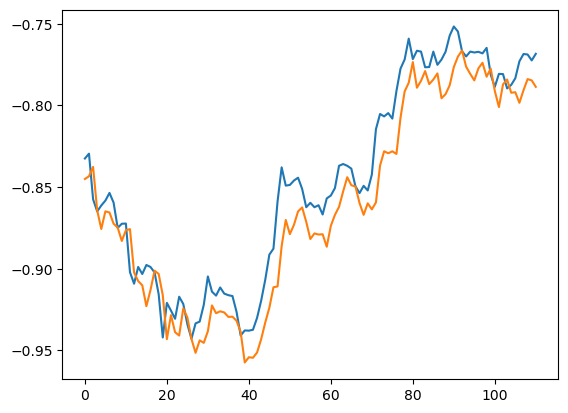

In [157]:
plt.plot(y_val[:111])
plt.plot(predictions1[:111])

In [158]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))

In [159]:
y_val = scaler_star.inverse_transform(y_val)

In [160]:
criterion(torch.Tensor(predictions1),torch.Tensor(y_val)).item()

2.605222463607788

In [161]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [162]:
winrate(y_train.reshape(-1,), predictions2)

0.4723776223776224

In [163]:
y_train = scaler_star.inverse_transform(y_train)

In [164]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [165]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(5.8511)

In [166]:
torch.save(model.state_dict(), f'ЧВЕСА/[len(companies)=4,512,8,1,0.0]TRANS(ENC) (M F=TI) 1D|W=0.4735, TL=3.8511 VL=2.6052' )